# Abelian Sandpile

This notebook answers the questions given in the assignment, and removes all the extra explanations. The questions we wanted to answer were:

1. Implement the Abelian Sandpile model and simulate its dynamics. I've included a template of for the solution below, although feel free to re-factor if you would prefer to implement the problem a different way.
2. Using the code included below, show that your model exhibits a $1/T^\alpha$ waiting time between avalanches, where $\alpha$ is some constant.
3. If a single image of the sandpile has size $N$ (the total number of lattice sites), what do you expect to be the worst-case scaling of the runtime of your algorithm? What about the expected scaling of memory usage?
4. (Hard, optional) Try [vectorizing](https://realpython.com/numpy-array-programming/) your sandpile implementation, in order to reduce the number of "for" loops used in your implementation. How does vectorization affect the runtime?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1 - just getting the Abelian sandpile running

In [5]:
# First addressing question one, which is just implementing the Abelian sandpile. I really just edited the given shell

from tkinter import N
from turtle import end_fill


class AbelianSandpile:
    """
    An Abelian sandpile model simulation. The sandpile is initialized with a random
    number of grains at each lattice site. Then, a single grain is dropped at a random
    location. The sandpile is then allowed to evolve until it is stable. This process
    is repeated n_step times.
    
    Parameters:
    n (int): The size of the grid
    grid (np.ndarray): The grid of the sandpile
    history (list): A list of the sandpile grids at each timestep
    all_durations (list): A list of the durations of each avalanche
    """

    def __init__(self, n=100, random_state=None):
        self.n = n
        np.random.seed(random_state) # Set the random seed
        self.grid = np.random.choice([0, 1, 2, 3], size=(n, n))
        self.history =[self.grid.copy()] # Why did we need to copy the grid?
        self.all_durations = list() # useful to keep track of the duration of toppling events
        # I'm adding this, not sure yet if needed
        self.avalanch_happened = list()  # a place to keep track of the step at which an avalanch happened
        self.total_changes = list() # a place to keep track of the total changes that occur per step

    # I added this function to the class, this is how I'll have a cell check its neighbors
    # (and then they'll check their neighbors (and then they'll check their neighbors...))

    def avalanch(grid, n, x, y, k):
        grid[x, y] += 1
        if grid[x,y] >= 4:
            k += 1
            grid[x,y] -= 4
            if x != 0:
                grid, k = AbelianSandpile.avalanch(grid, n, x-1, y, k)
            if x != n-1:
                grid, k = AbelianSandpile.avalanch(grid, n, x+1, y, k)
            if y != 0:
                grid, k = AbelianSandpile.avalanch(grid, n, x, y-1, k)
            if y != n-1:
                grid, k = AbelianSandpile.avalanch(grid, n, x, y+1, k)

        return grid, k


    def step(self):
        """
        Perform a single step of the sandpile model. Recall that there are two 
        timescales in this problem; step corresponds to the longer timescale of a 
        single sandgrain addition.

        A single step of the simulation consists of two stages: a random sand grain is 
        dropped onto the lattice at a random location. Then, a set of avalanches occurs
        causing sandgrains to get redistributed to their neighboring locations.

        Returns: None
        """
        
        ########## my code here ############

        # First deciding where we want to drop a grain of sand

        drop = np.random.choice(np.arange(0, self.n), size = (2))

        # Now we want to solve for the toppling events, based on where the grain fell
        
        grid_new, k = AbelianSandpile.avalanch(self.grid, self.n, drop[0], drop[1], 0)

        self.history.append(grid_new.copy())
        self.all_durations.append(k)
        self.grid = grid_new

    # we use this decorator for class methods that don't require any of the attributes 
    # stored in self. Notice how we don't pass self to the method
    @staticmethod
    def check_difference(grid1, grid2):
        """Check the total number of different sites between two grids"""
        return np.sum(grid1 != grid2)

    
    def simulate(self, n_step):
        """
        Simulate the sandpile model for n_step steps.
        """
        # My code: 
        for j in np.arange(0, n_step+1):
            AbelianSandpile.step(self)
            total_change= AbelianSandpile.check_difference(self.history[j], self.history[j-1])

            # adding the below lists

            self.total_changes.append(total_change)
            if total_change > 1:
                self.avalanch_happened.append(j)

Text(0.5, 1.0, 'Avalanch activity in most recent timesteps')

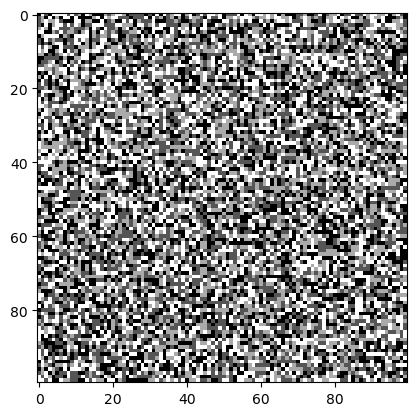

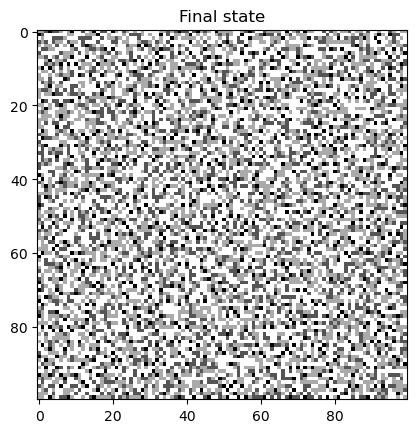

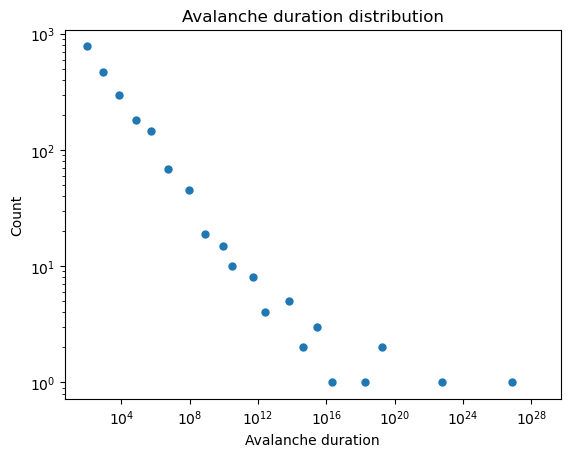

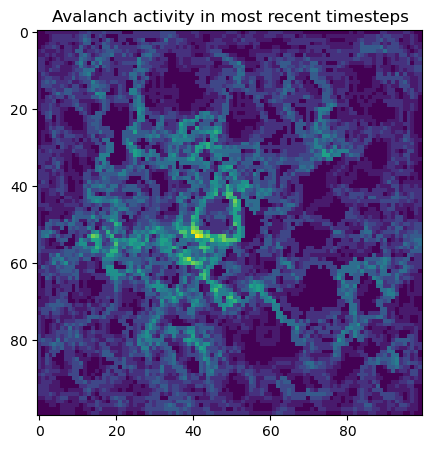

In [6]:
# this block runs the simulation and produces pretty plots (all from the original jupyter notebook)

# Run sandpile simulation
model = AbelianSandpile(n=100, random_state=0)

plt.figure()
plt.imshow(model.grid, cmap='gray')

model.simulate(10000)
plt.figure()
plt.imshow(model.grid, cmap='gray')
plt.title("Final state")

# Compute the pairwise difference between all observed snapshots. This command uses list
# comprehension, a zip generator, and argument unpacking in order to perform this task
# concisely.
all_events = [model.check_difference(*states) for states in zip(model.history[:-1], model.history[1:])]
# remove transients before the self-organized critical state is reached
all_events = all_events[1000:]
# index each timestep by timepoint
all_events = list(enumerate(all_events))
# remove cases where an avalanche did not occur
all_avalanches = [x for x in all_events if x[1] > 1]
all_avalanche_times = [item[0] for item in all_avalanches]
all_avalanche_sizes = [item[1] for item in all_avalanches]
all_avalanche_durations = [event1 - event0 for event0, event1 in zip(all_avalanche_times[:-1], all_avalanche_times[1:])]

log_bins = np.logspace(np.log10(2), np.log10(np.max(all_avalanche_durations)), 50) # logarithmic bins for histogram
vals, bins = np.histogram(all_avalanche_durations, bins=log_bins)
plt.figure()
plt.loglog(10**bins[:-1], vals, '.', markersize=10)
plt.title('Avalanche duration distribution')
plt.xlabel('Avalanche duration')
plt.ylabel('Count')

## Visualize activity of the avalanches
# Make an array storing all pairwise differences between the lattice at successive
# timepoints
all_diffs = np.abs(np.diff(np.array(model.history), axis=0))
all_diffs[all_diffs > 0] = 1
all_diffs = all_diffs[np.sum(all_diffs, axis=(1, 2)) > 1] # Filter to only keep big events
most_recent_events = np.sum(all_diffs[-100:], axis=0)
plt.figure(figsize=(5, 5))
plt.imshow(most_recent_events)
plt.title("Avalanch activity in most recent timesteps")

## Question 2 - looking at time between avalanches

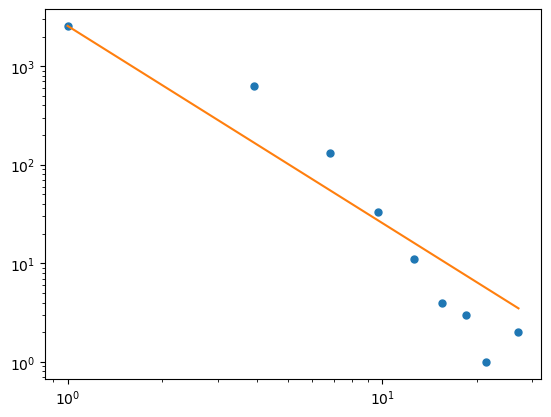

In [58]:
# Now we want to show that there is a 1 / T^{alpha} waiting time between avalanch events.
# The slope of the histogram points should roughly be alpha

vals, bins = np.histogram(all_avalanche_durations)
log_bins = np.logspace(np.log10(2), np.log10(np.max(all_avalanche_durations)), 50) # logarithmic bins for histogram
# vals, bins = np.histogram(all_avalanche_durations, bins=log_bins)
plt.figure()
plt.loglog(bins[:-1], vals, '.',  markersize=10)
plt.loglog(bins[:-1], (vals[0] / bins[0]) * bins[:-1]**(-2)) # plot 1/T scaling


## Question 3 

If we're using a recursive solution I think the only thing that can make the scaling worse is if we make the grid larger. We're already checking cells fairly minimally -- whenever an avalanch occurs at a cell we check our neighbors and then they check their neighbors and so on, moving on in a branching outward pattern. It seems like this algorithm is only checking a cell once and then moving on. If we weren't using recursion we might end up checking a cell multiple times, which would lead to unnecessary memory usage. ***Come back here and think about this more****

# Percolation 

1. Implement a two dimensional directed percolation model in Python. I've included my code outline below.
    + The naive solution simulates water pouring into the top row, and then iterate over rows and sites
    + Can you think of a faster way of solving this problem? (Hint: we may not have seen recursion in class yet, but it may be helpful). If you want to try implementing your solution, you will need to add an additional private method `_flow_recursive(i, j)` that contains the recursive logic
2. Perform replicate simulations using the code I've provided below, create a plot showing how the probability of percolation changes as a function of N (the lattice size). Beyond seeing the predictable percolation to clogging transition, you'll notice that the variance in the outcome of your simulations behaves unexpectedly. What is going on here? (Hint: If you've studied the Ising model, you've seen something like this before)
3. Theoretically, does the transition point seen in our empirical results align with your intuition? Can you make a simple statistical argument for the percolation threshold? (Hint: think about counting occupied sites versus counting links between sites).
4. How does the memory usage and runtime of your percolation model implement scale with the lattice size? You can answer this empirically or theoretically.
5. For the sandpile model, we noted the existence of two timescales: the slow timescale (addition of sand grains) and the fast timescale (avalanches and topples). These two timescales were reflected in how we chose to implement our simulation. What are the relevant timescales for the directed percolation simulation? (Hint: watch the videos of the simulation on the class website for ideas)

## Question 1 - implementing the percolation problem

In [62]:
from time import perf_counter


class PercolationSimulation:
    """
    A simulation of a 2D directed percolation problem. Given a 2D lattice, open sites
    are denoted by 0s, and blocked sites are denoted by 1s. During a simulation, water is
    poured into the top of the grid, and allowed to percolate to the bottom. If water
    fills a lattice site, it is marked with a 2 in the grid. Water only reaches a site
    if it reaches an open site directly above, or to the immediate left or right 
    of an open site.

    I've included the API for my solution below. You can use this as a starting point, 
    or you can re-factor the code to your own style. Your final solution must have a 
    method called percolate that creates a random lattice and runs a percolation 
    simulation and
    1. returns True if the system percolates
    2. stores the original lattice in self.grid
    3. stores the water filled lattice in self.grid_filled

    + For simplicity, use the first dimension of the array as the percolation direction
    + For boundary conditions, assume that any site out of bounds is a 0 (occupied)
    + You should use numpy for this problem, although it is possible to use lists 

    Attributes:
        grid (np.array): the original lattice of blocked (0) and open (1) sites
        grid_filled (np.array): the lattice after water has been poured in
        n (int): number of rows and columns in the lattice
        p (float): probability of a site being blocked in the randomly-sampled lattice
        random_state (int): random seed for numpy's random number generator. Used to 
            ensure reproducibility across random simulations. The default value of None
            will use the current state of the random number generator without resetting
            it.
    """

    def __init__(self, n=100, p=0.5, grid=None, random_state=None):
        """
        Initialize a PercolationSimulation object.

        Args:
            n (int): number of rows and columns in the lattice
            p (float): probability of a site being blocked in the randomly-sampled lattice
            random_state (int): random seed for numpy's random number generator. Used to
                ensure reproducibility across random simulations. The default value of None
                will use the current state of the random number generator without resetting
                it.
        """

        self.random_state = random_state # the random seed

        # Initialize a random grid if one is not provided. Otherwise, use the provided
        # grid.
        if grid is None:
            self.n = n
            self.p = p
            self.grid = np.zeros((n, n))
            self._initialize_grid()
        else:
            assert len(np.unique(np.ravel(grid))) <= 2, "Grid must only contain 0s and 1s"
            self.grid = grid.astype(int)
            # override numbers if grid is provided
            self.n = grid.shape[0]
            self.p = 1 - np.mean(grid)

        # The filled grid used in the percolation calculation. Initialize to the original
        # grid. We technically don't need to copy the original grid if we want to save
        # memory, but it makes the code easier to debug if this is a separate variable 
        # from self.grid.
        self.grid_filled = np.copy(self.grid)

    def _initialize_grid(self):
        """
        Sample a random lattice for the percolation simulation. This method should
        write new values to the self.grid and self.grid_filled attributes. Make sure
        to set the random seed inside this method.

        This is a helper function for the percolation algorithm, and so we denote it 
        with an underscore in order to indicate that it is not a public method (it is 
        used internally by the class, but end users should not call it). In other 
        languages like Java, private methods are not accessible outside the class, but
        in Python, they are accessible but access is discouraged by convention.

        Private methods are useful for functions that are necessary to support the 
        public methods (here, our percolate() method), but which we expect we might need
        to alter in the future. If we released our code as a library, others might 
        build software that accesses percolate(), and so we should not alter the 
        input/outputs because it's a public method
        """
        ###############################################################################

        np.random.seed(self.random_state) # Set the random seed
        self.grid = np.random.choice([0, 1], size=(self.n, self.n), p = [1-self.p, self.p])
        self.grid_filled = self.grid.copy()

        ###############################################################################
        

    def _flow_recursive(self, i, j):
        """
        Only used if we opt for a recursive solution.

        The recursive portion of the flow simulation. Notice how grid and grid_filled
        are used to keep track of the global state, even as our recursive calls nest
        deeper and deeper
        """
        #############################################################################

        if j != 0:
            if self.grid_filled[i,j-1] == 0: 
                self.grid_filled[i, j-1] = 2 
                PercolationSimulation._flow_recursive(self, i, j-1)
        if j != self.n - 1:
            if self.grid_filled[i,j+1] == 0:
                self.grid_filled[i,j+1] = 2
                PercolationSimulation._flow_recursive(self, i, j+1)
        if i != 0:
            if self.grid_filled[i-1, j] == 0:
                self.grid_filled[i-1, j] = 2
                PercolationSimulation._flow_recursive(self, i-1, j)
        if i != self.n - 1:
            if self.grid_filled[i+1, j] == 0:
                self.grid_filled[i+1, j] = 2
                PercolationSimulation._flow_recursive(self, i+1, j)

        
        ###############################################################################s


    def _flow(self):
        """
        Run a percolation simulation using recursion

        This method writes to the grid and grid_filled attributes, but it does not
        return anything. In other languages like Java or C, this method would return
        void
        """
        ###############################################################################
        
        for j in range(0, self.n):
            if self.grid_filled[0,j] == 0:
                self.grid_filled[0,j] = 2
                PercolationSimulation._flow_recursive(self, 0, j)

        ###############################################################################


    def percolate(self):
        """
        Initialize a random lattice and then run a percolation simulation. Report results
        
        """
        ###############################################################################

        PercolationSimulation._initialize_grid(self)
        if 0 in self.grid[0, :]:
            PercolationSimulation._flow(self)
        
        if 2 in self.grid_filled[self.n-1, :]:
            return 1
        else:
            return 0
        
        ###############################################################################



Running the simulation:

1
1
0


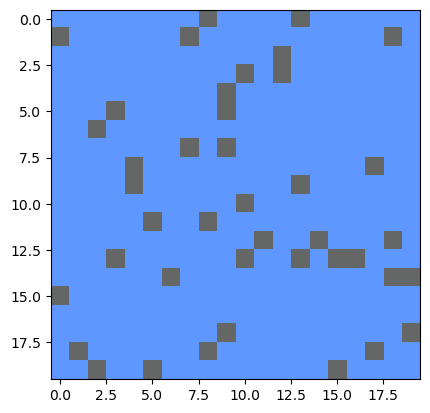

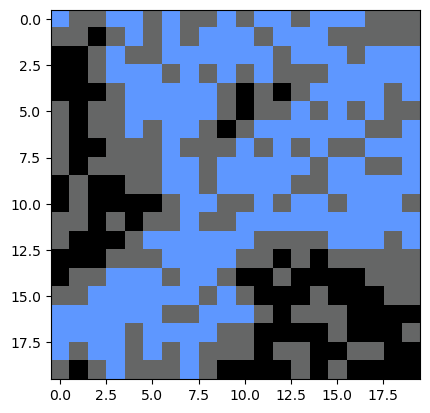

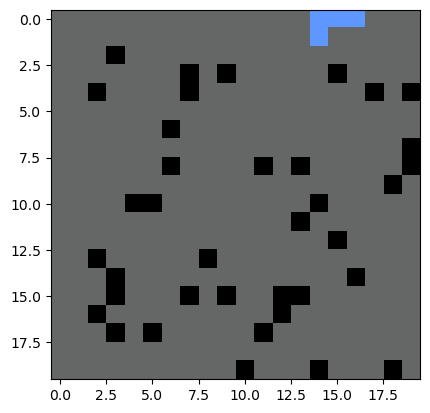

In [63]:
# Import William's solution
# from solutions.percolation import PercolationSimulation

from matplotlib.colors import LinearSegmentedColormap
def plot_percolation(mat):
    """
    Plots a percolation matrix, where 0 indicates an empty site, 1 indicates a blocked 
    site, and 2 indicates a filled site
    """
    cvals  = [0, 1, 2]
    colors = [(0, 0, 0), (0.4, 0.4, 0.4), (0.372549, 0.596078, 1)]

    norm = plt.Normalize(min(cvals), max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = LinearSegmentedColormap.from_list("", tuples)
    plt.imshow(mat, cmap=cmap, vmin=0, vmax=2)


model = PercolationSimulation(n=20, random_state=0, p=0.1)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

model = PercolationSimulation(n=20, random_state=0, p=0.4)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

model = PercolationSimulation(n=20, random_state=0, p=0.9)
print(model.percolate())
plt.figure()
plot_percolation(model.grid_filled)

## Question 2 - looking at how percolation scales as a function of the grid size

First we create the replicate simulations using William's code. The way I'm doing this is by first choosing which $N$ sizes we want to run over, in my case I pick $N$ between 10 and 35. Then I run a bunch of simulations. For each $n$ we go over all the $p$ values that determine the probability of a site being filled, and for each $p$ run the simulation a number of times. Most of this is just me editing William's code:

In [70]:
# Now we want to create a plot of the probability of percolating versus the grid size N

# First we need to again run our replicate simulations 
pvals = np.linspace(0, 1, 25) # control parameter for percolation phase transition
n_reps = 200 # number of times to repeat the simulation for each p value
N_vals = np.arange(10, 35) # the grid sizes to run over

all_percolations_means = list()

# for every N we'll run the replicate simulations
for n in N_vals:
    all_percolations = list()
    for p in pvals:
        all_replicates = list()
        for i in range(n_reps):
            # Initialize the model
            model = PercolationSimulation(n, p=p)
            all_replicates.append(model.percolate())
        all_percolations.append(all_replicates)
    all_percolations_means.append(np.mean(np.array(all_percolations), axis=1))
    


Running replicate simulations for p = 0.0
Running replicate simulations for p = 0.041666666666666664
Running replicate simulations for p = 0.08333333333333333
Running replicate simulations for p = 0.125
Running replicate simulations for p = 0.16666666666666666
Running replicate simulations for p = 0.20833333333333331
Running replicate simulations for p = 0.25
Running replicate simulations for p = 0.29166666666666663
Running replicate simulations for p = 0.3333333333333333
Running replicate simulations for p = 0.375
Running replicate simulations for p = 0.41666666666666663
Running replicate simulations for p = 0.4583333333333333
Running replicate simulations for p = 0.5
Running replicate simulations for p = 0.5416666666666666
Running replicate simulations for p = 0.5833333333333333
Running replicate simulations for p = 0.625
Running replicate simulations for p = 0.6666666666666666
Running replicate simulations for p = 0.7083333333333333
Running replicate simulations for p = 0.75
Running

Now we've run the simulations, we can again look at the percolation probability as a function of the average site occupation probability, now for all of the different $N$ values:

Text(0, 0.5, 'Percolation probability')

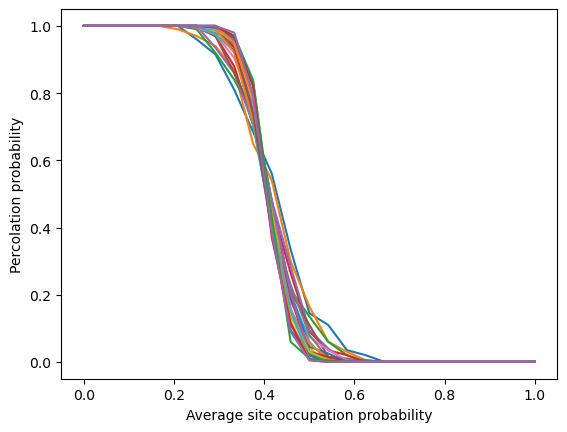

In [74]:
plt.figure()

for j in np.arange(0,25):
    plt.plot(pvals, all_percolations_means[j])

plt.xlabel('Average site occupation probability')
plt.ylabel('Percolation probability')


It's a little tricky to see what's going on here, but I believe that as we increase the grid size $N$, this plot comes closer and closer to being a step function. I can only increase $N$ so much before I'm told that I reach maximum recursion depth, but we get pretty close in the final plot, where $N = 35$:

Text(0.5, 1.0, 'N = 35')

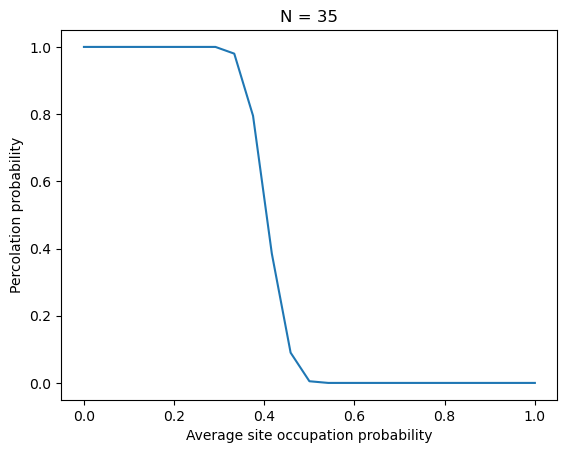

In [82]:
plt.figure
plt.plot(pvals, all_percolations_means[24])
plt.xlabel('Average site occupation probability')
plt.ylabel('Percolation probability')
plt.title('N = 35')


We're then asked about the variance of our solutions, and I think this has to do with the fact that, just because the probability of percolating decreases rapidly at $p = 0.4$, it doesn't mean that we won't still percolate. If we run a few simulations as before but fixing this $p$ value, we see the following:

0
1
0
1
0


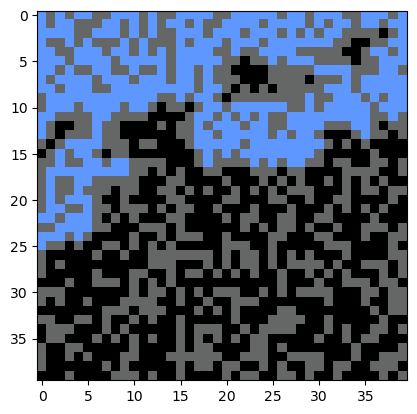

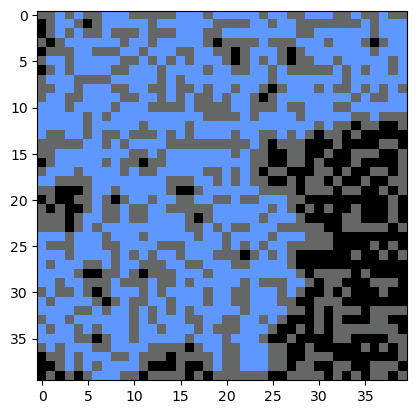

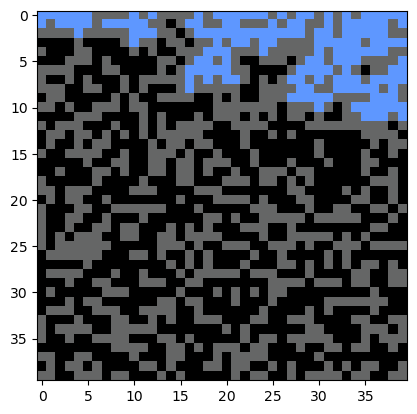

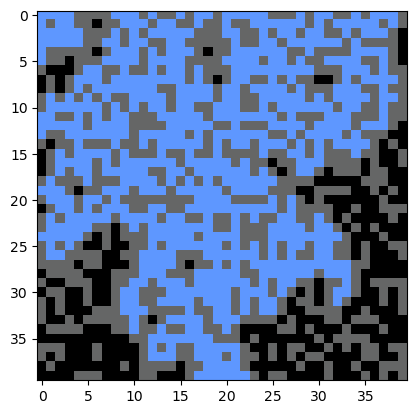

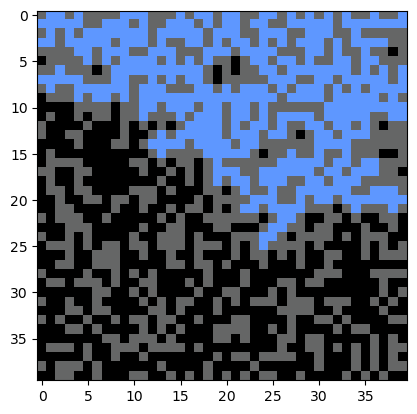

In [96]:
for j in np.arange(0,5):
    model = PercolationSimulation(n=40, p=0.41)
    print(model.percolate())
    plt.figure()
    plot_percolation(model.grid_filled)


We end up seeing a pretty large range of outcomes regarding if we did or did not percolate. I'm not entirely sure what would cause this, but I would guess it has to do with the inherent randomness in whether or not a site is filled?